In [1]:
!pip install category_encoders
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
###DataFrame 불러오기###
df_origin = pd.read_csv('/content/drive/MyDrive/Data/wowah_data.csv')
#df_sample = df_origin.sample(frac=0.01, random_state=85567)

In [4]:
###DataFrame EDA###
def data_eda(df):
  df.columns = ['Char', 'Level', 'Race', 'Charclass', 'Zone', 'Guild', 'Timestamp']
  df = df.drop_duplicates()
  df['Guild'] = df['Guild'].apply(lambda x: 0 if x==-1 else 1)
  df.reset_index(drop=True, inplace=True)
  return df
###Column 이름 변경, 중복 제외, 'Guild' 가입 유무로 변경('-1'은 미가입)
###index reset

In [5]:
df_data_eda = data_eda(df_origin)

In [6]:
df_data_eda.duplicated().sum()

0

In [7]:
df_data_eda

,Char,Level,Race,Charclass,Zone,Guild,Timestamp
0,59425,1,Orc,Rogue,Orgrimmar,1,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,0,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,0,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,0,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,0,01/01/08 00:02:09
...,...,...,...,...,...,...,...
10823172,86766,80,Blood Elf,Death Knight,Halls of Lightning,1,12/31/08 23:50:18
10823173,86497,77,Blood Elf,Death Knight,The Storm Peaks,1,12/31/08 23:50:18
10823174,34893,80,Blood Elf,Death Knight,The Storm Peaks,1,12/31/08 23:50:18
10823175,86881,80,Blood Elf,Death Knight,Dragonblight,1,12/31/08 23:50:18


In [8]:
###Timestamp Column 나누기###
def timestamp(df):
  df = df.astype({'Timestamp':'datetime64'})
  df['Month'] = df['Timestamp'].dt.month
  df['Day'] = df['Timestamp'].dt.day
  df['Hour'] = df['Timestamp'].dt.hour
  df.drop('Timestamp', axis=1, inplace=True)
  df.sort_values('Month', inplace=True)
  return df
###Timestamp DataType datetime64로 변경
###월, 일, 시간 Column 만들기
###Timestamp 삭제
###'Month'기준으로 정렬

In [9]:
df_timestamp = timestamp(df_data_eda)

In [10]:
df_timestamp['Char'].value_counts().describe()

count    37354.000000
mean       289.746132
std        956.669110
min          1.000000
25%          2.000000
50%          6.000000
75%         59.000000
max      42770.000000
Name: Char, dtype: float64

In [11]:
def charcounts(df):#956.669110, 16.133414
  df_charcount = pd.DataFrame(df['Char'].value_counts())
  df_charcount.reset_index(inplace=True)
  df_charcount.rename(columns={'index' : 'Char', 'Char' : 'Charcount'}, inplace=True)
  df_merge = pd.merge(df, df_charcount)
  df_merge['Subscribe'] = df_merge['Charcount'] > 956.669110
  return df_merge

In [12]:
df_charcounts = charcounts(df_timestamp)

In [13]:
df_charcounts

,Char,Level,Race,Charclass,Zone,Guild,Month,Day,Hour,Charcount,Subscribe
0,59425,1,Orc,Rogue,Orgrimmar,1,1,1,0,52,False
1,59425,1,Orc,Rogue,Orgrimmar,1,1,18,2,52,False
2,59425,1,Orc,Rogue,Orgrimmar,1,1,29,1,52,False
3,59425,1,Orc,Rogue,Orgrimmar,1,1,5,21,52,False
4,59425,1,Orc,Rogue,Orgrimmar,1,1,2,1,52,False
...,...,...,...,...,...,...,...,...,...,...,...
10823172,38722,62,Blood Elf,Hunter,Zangarmarsh,0,12,11,22,2,False
10823173,38722,62,Blood Elf,Hunter,Zangarmarsh,0,12,11,22,2,False
10823174,89439,1,Blood Elf,Paladin,Eversong Woods,0,12,11,22,1,False
10823175,89442,1,Blood Elf,Rogue,Eversong Woods,0,12,11,22,1,False


In [14]:
#sns.barplot(data=df_charcounts,x='Subscribe', y=);
df_charcounts['Char'].mode()

0    182
dtype: int64

In [15]:
df_charcounts['Char'].value_counts()[:5]

182      42770
57741    16237
1384     15878
59489    13977
62239    13776
Name: Char, dtype: int64

In [16]:
###기준모델 True 0.81014
df_charcounts['Subscribe'].value_counts(normalize=True)

True     0.81014
False    0.18986
Name: Subscribe, dtype: float64

In [17]:
train, test = train_test_split(df_charcounts, test_size=0.2, random_state=2)

In [18]:
target = 'Subscribe'
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [19]:
pipe = make_pipeline(
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=42)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_test, y_test))

검증 정확도:  1.0


In [20]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_test, y_test))

검증 정확도:  1.0


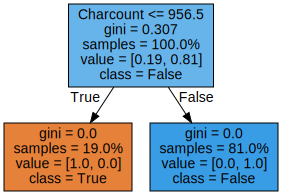

In [21]:
import graphviz
from sklearn.tree import export_graphviz

tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

In [22]:
features = train.columns.drop([target, 'Charcount'])
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [23]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_test, y_test))

검증 정확도:  0.8837328770287476


Text(0.5, 1.0, 'Confusion matrix, n = 2164636')

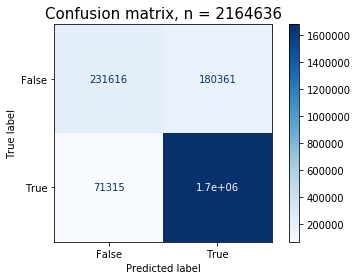

In [24]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_test, y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_test)}', fontsize=15)

In [25]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.56      0.65    411977
        True       0.90      0.96      0.93   1752659

    accuracy                           0.88   2164636
   macro avg       0.83      0.76      0.79   2164636
weighted avg       0.88      0.88      0.88   2164636



In [26]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[:, -1]
print('AUC score: ', roc_auc_score(y_test, y_pred_proba))

AUC score:  0.8538701424013955


Text(0, 0.5, 'TPR')

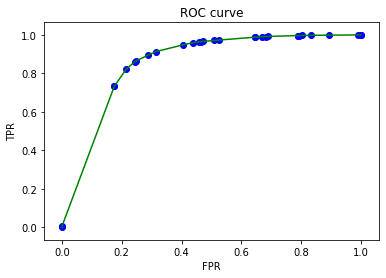

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [28]:
#Char	Level Race	Charclass	Zone	Guild	Month	Day	Hour	Subscribe
feature = 'Level'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


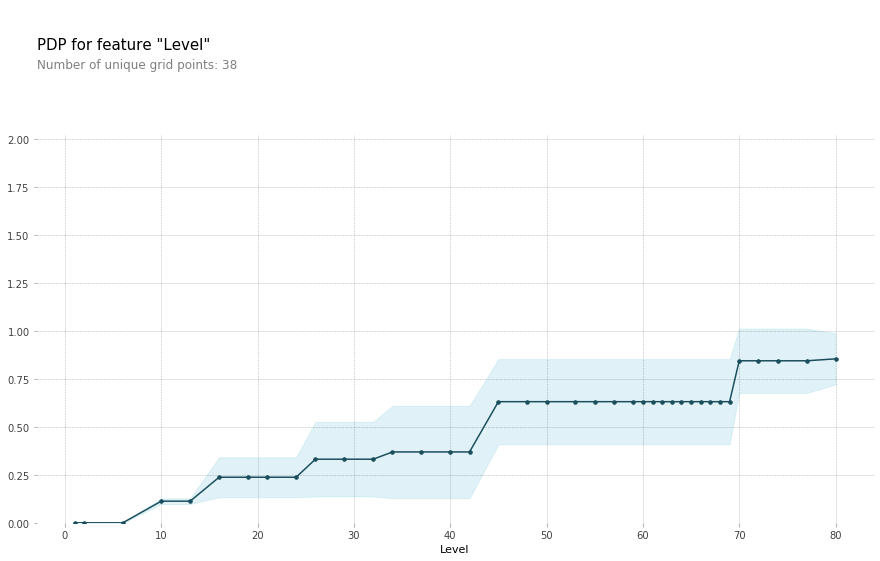

In [29]:
pdp_plot(isolated, feature_name=feature);

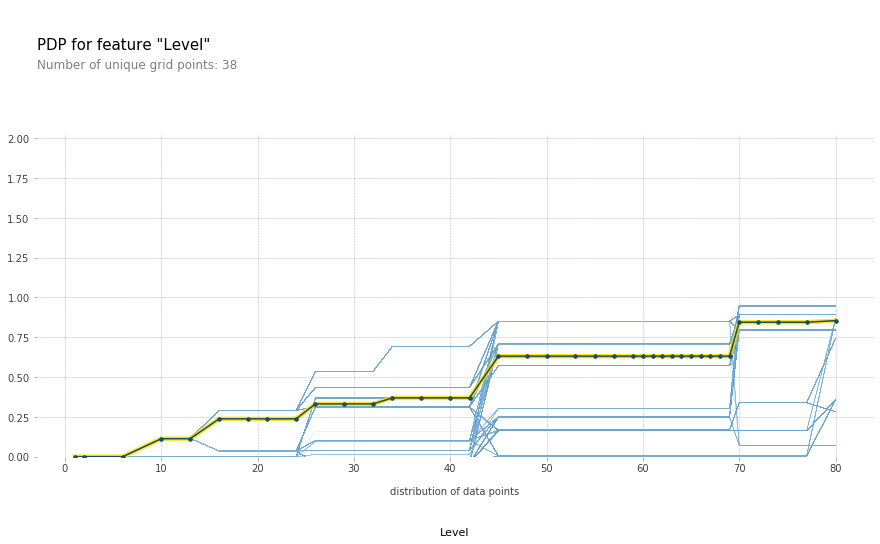

In [30]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 
         , plot_pts_dist=True) 

plt.xlim(20000,150000);